In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!nvidia-smi

Fri Apr  7 16:53:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import necessary libraries

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os, time, pickle, json 
import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict 
from statistics import mean 
from tqdm import tqdm 
import torch 
import torch.nn as nn 
from torchvision import transforms 
from torchvision.utils import save_image 
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split

### Preprocessing (Data parsing and formatting)


In [ ]:
MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)


RESIZE = 128 

def read_path(filepath) :
    masked_files = glob.glob(filepath + "*/Masked_Train/*.jp*")
    unmasked_files = [i.replace("Masked_Train", "Unmasked_Train") for i in masked_files]
    return masked_files, unmasked_files 


class Transform():
    def __init__(self, resize=RESIZE, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([
            transforms.Resize((resize, resize)), 
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)

    
class Dataset(object):
    def __init__(self, masked_files, unmasked_files):
        self.masked_files = masked_files 
        self.unmasked_files = unmasked_files
        self.trasform_obj = Transform()
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        masked = Image.open(self.masked_files[idx])
        unmasked = Image.open(self.unmasked_files[idx])
        masked_tensor = self.trasform_obj(masked)
        unmasked_tensor = self.trasform_obj(unmasked)
        return masked_tensor, unmasked_tensor 
    
    def __len__(self):
        return len(self.masked_files)
    
def show_img_sample(img: torch.Tensor, img1: torch.Tensor):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    ax = axes.ravel()
    print(img.shape)
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_title("input image", c="g")
    ax[1].imshow(img1.permute(1, 2, 0))
    ax[1].set_title("label image", c="b")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
Training_data_path = "/kaggle/input/photo-reconstruction/Dataset/Training_Data/"

masked, unmasked = read_path(Training_data_path)

train_masked, val_masked, train_unmasked, val_unmasked = train_test_split(masked, unmasked, test_size=0.2)
train_ds = Dataset(train_masked, train_unmasked)
val_ds = Dataset(val_masked, val_unmasked)

print(len(masked), len(train_ds), len(val_ds))

6997 5597 1400


In [ ]:
print(val_ds.__getitem__(5)[0].shape)

torch.Size([3, 128, 128])


torch.Size([3, 128, 128])


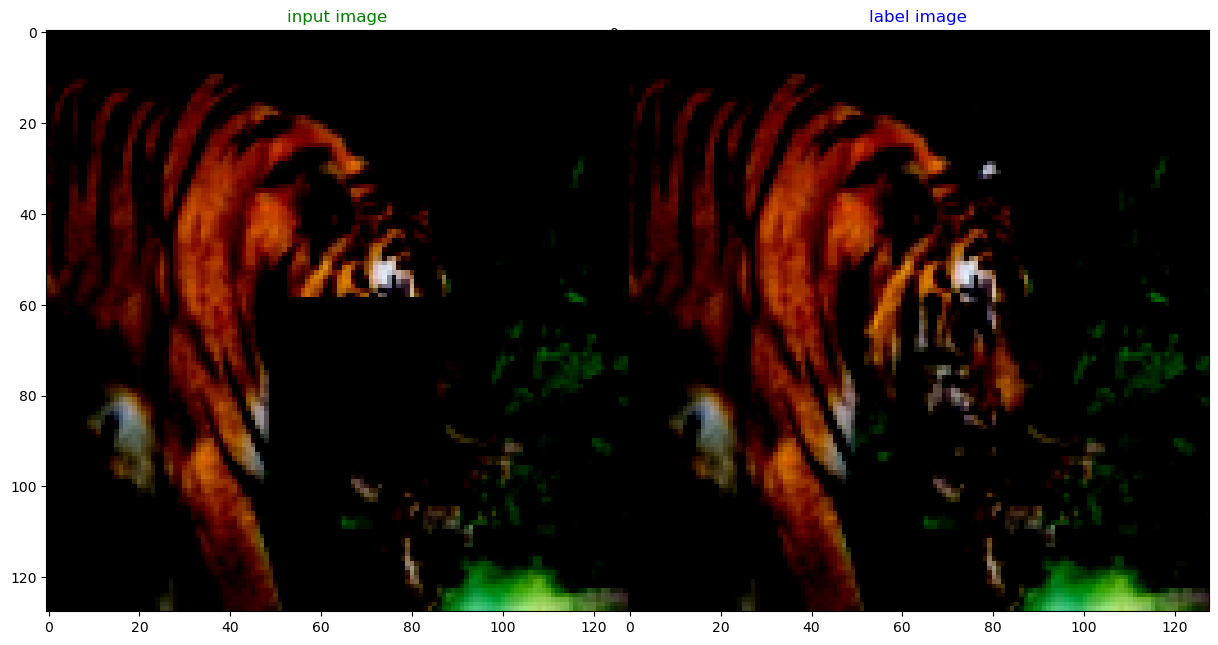

In [ ]:
show_img_sample(train_ds.__getitem__(7)[0], train_ds.__getitem__(7)[1])

In [ ]:
BATCH_SIZE = 32
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

### Model Creation (Pix2Pix)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 = self.conv2Relu(3, 64, 5)
        self.enc2 = self.conv2Relu(64, 128, pool_size=4)
        self.enc3 = self.conv2Relu(128, 256, pool_size=2)
        self.enc4 = self.conv2Relu(256, 512, pool_size=2)
        
        self.dec1 = self.deconv2Relu(512, 256, pool_size=2)
        self.dec2 = self.deconv2Relu(256+256, 128, pool_size=2)
        self.dec3 = self.deconv2Relu(128+128, 64, pool_size=4)
        self.dec4 = nn.Sequential(
            nn.Conv2d(64+64, 3, 5, padding=2), 
            nn.Tanh()
        )
        
    def conv2Relu(self, in_c, out_c, kernel_size=3, pool_size=None):
        layer = []
        if pool_size:
            layer.append(nn.AvgPool2d(pool_size))
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, padding=(kernel_size-1)//2))
        layer.append(nn.LeakyReLU(0.2, inplace=True))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)
    
    def deconv2Relu(self, in_c, out_c, kernel_size=3, stride=1, pool_size=None):
        layer = []
        if pool_size:
            layer.append(nn.UpsamplingNearest2d(scale_factor=pool_size))
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, stride, padding=1))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)
    
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3) 
        
        out = self.dec1(x4)
        out = self.dec2(torch.cat((out, x3), dim=1)) 
        out = self.dec3(torch.cat((out, x2), dim=1))
        out = self.dec4(torch.cat((out, x1), dim=1))
        return out 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = self.conv2relu(6, 32, 5, cnt=1)
        self.layer2 = self.conv2relu(32, 64, pool_size=4)
        self.layer3 = self.conv2relu(64, 128, pool_size=2)
        self.layer4 = self.conv2relu(128, 256, pool_size=2)
        self.layer5 = self.conv2relu(256, 512, pool_size=2)
        self.layer6 = nn.Conv2d(512, 1, kernel_size=1)
        
    def conv2relu(self, in_c, out_c, kernel_size=3, pool_size=None, cnt=2):
        layer = []
        for i in range(cnt):
            if i == 0 and pool_size != None:
                layer.append(nn.AvgPool2d(pool_size))
            layer.append(nn.Conv2d(in_c if i == 0 else out_c, 
                                   out_c,
                                   kernel_size,
                                   padding=(kernel_size-1)//2))
            layer.append(nn.BatchNorm2d(out_c))
            layer.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layer)
        
    def forward(self, x, x1):
        x = torch.cat((x, x1), dim=1)
        out = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return self.layer6(out)

### Model Training

In [ ]:
def train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d):
    G.train()
    D.train()
    LAMBDA = 100.0
    total_loss_g, total_loss_d = [], []
    for i, (input_img, real_img) in enumerate(tqdm(train_dl)):
        input_img = input_img.to(device)
        real_img = real_img.to(device)
        real_label = torch.ones(input_img.size()[0], 1, 4, 4).to(device)
        fake_label = torch.zeros(input_img.size()[0], 1, 4, 4).to(device)

        # Generator 
        fake_img = G(input_img)
        fake_img_ = fake_img.detach() 
        out_fake = D(fake_img, input_img)
        loss_g_bce = criterion_bce(out_fake, real_label) 
        loss_g_mae = criterion_mae(fake_img, real_img)
        loss_g = loss_g_bce + LAMBDA * loss_g_mae 
        total_loss_g.append(loss_g.item())
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()

        # Discriminator
        out_real = D(real_img, input_img)
        loss_d_real = criterion_bce(out_real, real_label)
        out_fake = D(fake_img_, input_img)
        loss_d_fake = criterion_bce(out_fake, fake_label)
        loss_d = loss_d_real + loss_d_fake 
        total_loss_d.append(loss_d.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    return mean(total_loss_g), mean(total_loss_d), fake_img.detach().cpu() 


project_path = "/kaggle/working"

def saving_img(fake_img, e):
    os.makedirs(f"{project_path}/generated", exist_ok=True)
    save_image(fake_img, f"{project_path}/generated/fake{str(e)}.png", range=(-1.0, 1.0), normalize=True)

    
    
def saving_logs(result):
    with open(f"{project_path}/train.pkl", "wb") as f:
        pickle.dump([result], f)


def saving_model(D, G, e):
    os.makedirs(f"{project_path}/weight", exist_ok=True)
    torch.save(G.state_dict(), f"{project_path}/weight/G{str(e+1)}.pth")
    torch.save(D.state_dict(), f"{project_path}/weight/D{str(e+1)}.pth")
        
def show_losses(g, d):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax = axes.ravel()
    ax[0].plot(np.arange(len(g)).tolist(), g)
    ax[0].set_title("Generator Loss")
    ax[1].plot(np.arange(len(d)).tolist(), d)
    ax[1].set_title("Discriminator Loss")
    plt.show()


def train_loop(train_dl, G, D, num_epoch, lr, betas=(0.5, 0.999)):
    G.to(device)
    D.to(device)
    optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
    optimizer_d = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)
    criterion_mae = nn.L1Loss()
    criterion_bce = nn.BCEWithLogitsLoss()
    total_loss_d, total_loss_g = [], []
    result = {}
    
    for e in range(num_epoch):
        loss_g, loss_d, fake_img = train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d)
        total_loss_d.append(loss_d)
        total_loss_g.append(loss_g)
        saving_img(fake_img, e+1)
        print(f"For Epoch {e+1}, Generator loss: {loss_g} and Discriminator loss: {loss_d}")
        saving_model(D, G, e)  
    try:
        result["G"] = total_loss_d 
        result["D"] = total_loss_g 
        saving_logs(result)
        show_losses(total_loss_g, total_loss_d)
        saving_model(D, G, e)
        print("successfully save model")
    finally:
        return G, D 

### Training and Hyperparameters

100%|██████████| 174/174 [01:36<00:00,  1.81it/s]


For Epoch 1, Generator loss: 14.733209703160428 and Discriminator loss: 1.384102513050211


100%|██████████| 174/174 [01:02<00:00,  2.80it/s]


For Epoch 2, Generator loss: 11.21773336673605 and Discriminator loss: 1.270087295565112


100%|██████████| 174/174 [01:01<00:00,  2.82it/s]


For Epoch 3, Generator loss: 10.388190039272967 and Discriminator loss: 1.1971956912813515


100%|██████████| 174/174 [01:01<00:00,  2.82it/s]


For Epoch 4, Generator loss: 10.434380583379461 and Discriminator loss: 1.2735203874522243


100%|██████████| 174/174 [01:02<00:00,  2.80it/s]


For Epoch 5, Generator loss: 9.936712985751273 and Discriminator loss: 1.2885338276967235


100%|██████████| 174/174 [01:01<00:00,  2.82it/s]


For Epoch 6, Generator loss: 9.664441525251016 and Discriminator loss: 1.2668588229979592


100%|██████████| 174/174 [01:01<00:00,  2.82it/s]


For Epoch 7, Generator loss: 9.538130014792255 and Discriminator loss: 1.2580585794887325


100%|██████████| 174/174 [01:01<00:00,  2.84it/s]


For Epoch 8, Generator loss: 9.359846561804584 and Discriminator loss: 1.2744973716379582


100%|██████████| 174/174 [01:01<00:00,  2.82it/s]


For Epoch 9, Generator loss: 8.93286648563955 and Discriminator loss: 1.2761705449257774


100%|██████████| 174/174 [01:01<00:00,  2.82it/s]


For Epoch 10, Generator loss: 9.074208752862338 and Discriminator loss: 1.232426719761443


100%|██████████| 174/174 [01:01<00:00,  2.81it/s]


For Epoch 11, Generator loss: 8.898494854740713 and Discriminator loss: 1.2903906581388123


100%|██████████| 174/174 [01:01<00:00,  2.81it/s]


For Epoch 12, Generator loss: 8.644952442454196 and Discriminator loss: 1.2886209741406056


100%|██████████| 174/174 [01:01<00:00,  2.81it/s]


For Epoch 13, Generator loss: 8.811144612301355 and Discriminator loss: 1.3019410135417149


100%|██████████| 174/174 [01:01<00:00,  2.83it/s]


For Epoch 14, Generator loss: 8.793632806032553 and Discriminator loss: 1.3067273172153824


100%|██████████| 174/174 [01:01<00:00,  2.83it/s]


For Epoch 15, Generator loss: 8.514848407657666 and Discriminator loss: 1.2766687832344537


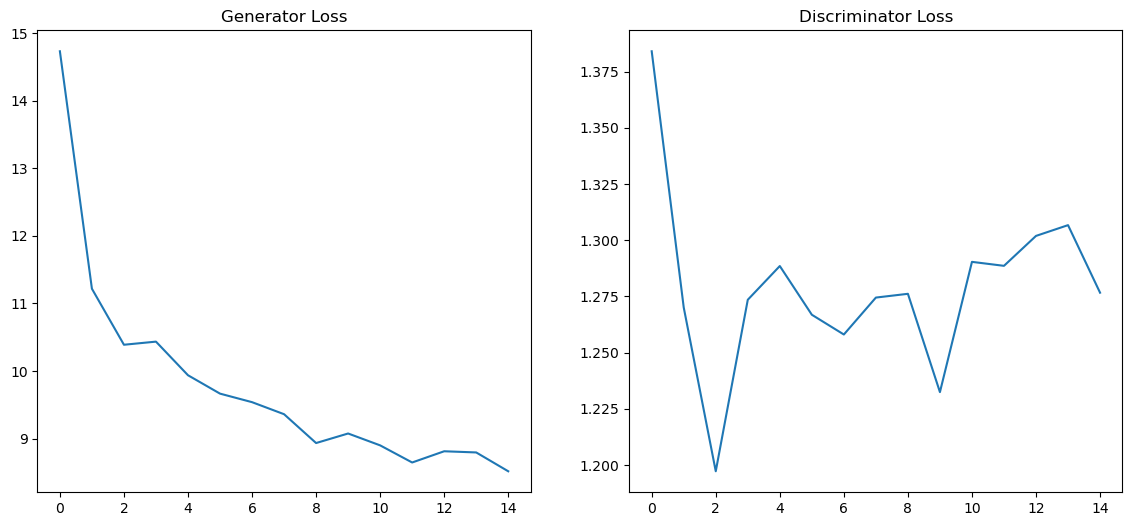

successfully save model


In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)
EPOCH = 15
learning_rate = 0.0002 
trained_G, trained_D = train_loop(train_dl, G, D, EPOCH, learning_rate)

### Testing

In [ ]:
output_path = '/kaggle/working'

def load_model(epoch_num):
    G = Generator()
    G.load_state_dict(torch.load(f"{output_path}/weight/G{epoch_num}.pth", map_location={"cuda:0": "cpu"}))
    G.eval()
    return G.to(device)

input_path = '/kaggle/input/photo-reconstruction'

def test_show_img(num_img, G):
    root = "generated"
    fig, axes = plt.subplots(int(num_img), 1, figsize=(12, 18))
    ax = axes.ravel()
    fpaths = glob.glob(f"{input_path}/Dataset/Testing_Data/*")[:int(num_img)]
    for i in range(int(num_img)):
        filename = fpaths[i]
        ax[i].imshow(Image.open(filename))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

def de_norm(img):
    img_ = img.mul(torch.FloatTensor(STD).view(3, 1, 1))
    img_ = img_.add(torch.FloatTensor(MEAN).view(3, 1, 1)).detach().numpy()
    img_ = np.transpose(img_, (1, 2, 0))
    return img_ 

def evaluate(val_dl, name, G):
    with torch.no_grad():
        fig, axes = plt.subplots(6, 8, figsize=(12, 12))
        ax = axes.ravel()
        for input_img, real_img in tqdm(val_dl):
            input_img = input_img.to(device)
            real_img = real_img.to(device)
            
            fake_img = G(input_img)
            batch_size = input_img.size()[0]
            batch_size_2 = batch_size * 2 
            
            for i in range(batch_size):
                ax[i].imshow(input_img[i].permute(1, 2, 0).detach().cpu().numpy())
                ax[i+batch_size].imshow(de_norm(real_img[i].detach().cpu()))
                ax[i+batch_size_2].imshow(de_norm(fake_img[i].detach().cpu()))
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                ax[i+batch_size].set_xticks([])
                ax[i+batch_size].set_yticks([])
                ax[i+batch_size_2].set_xticks([])
                ax[i+batch_size_2].set_yticks([])
                if i == 0:
                    ax[i].set_ylabel("Input Image", c="g")
                    ax[i+batch_size].set_ylabel("Real Image", c="b")
                    ax[i+batch_size_2].set_ylabel("Generated Image", c="r")
            plt.subplots_adjust(wspace=0, hspace=0)
            break   

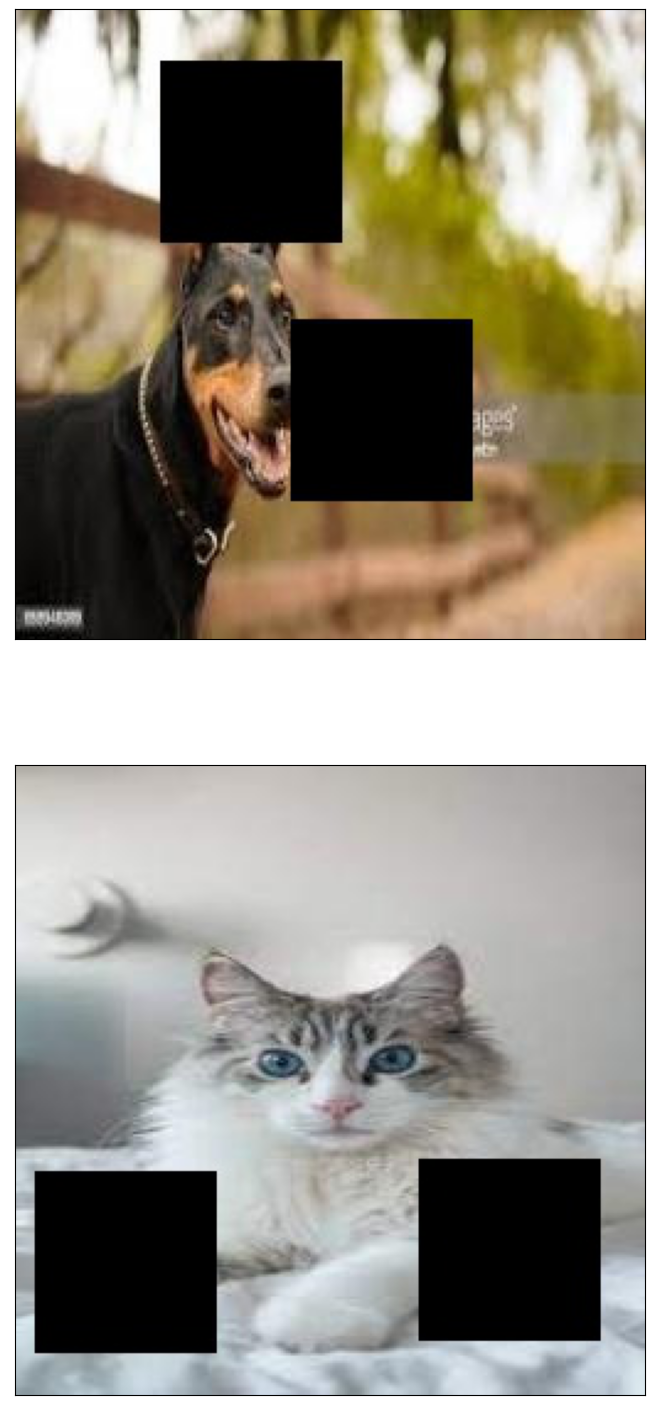

In [ ]:
test_show_img(2, trained_G)

### Creating the final Submission csv file

In [ ]:
IMSIZE = 128

def submission_csv_function (test_path):
    test_mask_data = pd.read_csv(test_path + 'masked_info.csv').drop(['Unnamed: 0'],axis=1)
    submission = []

    for i in range(len(test_mask_data)):
        filename, y1, x1, y2, x2 = test_mask_data.loc[i,]
        print(i+1)

        masked_image = Image.open(test_path + filename).resize((IMSIZE,IMSIZE))

        trasform_obj = Transform()

        masked_tensor = trasform_obj(masked_image).to(device)
        
        masked_tensor = masked_tensor.unsqueeze(0)

        generated_img = trained_G(masked_tensor)
        
        generated_img = generated_img.squeeze(0).cpu()

        # resize the tensor to shape 3x128x128
        image = torch.nn.functional.interpolate(generated_img.unsqueeze(0), size=256, mode='bicubic', align_corners=False).squeeze(0)
        
        image = image.detach()
        
        im = np.array(image)
        
        im = np.transpose(im, (1, 2, 0))
        
        (b, g, r) = cv2.split(im)
        
        result = np.zeros((256, 256))
        normalized_b = cv2.normalize(b,result, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        normalized_g = cv2.normalize(g,result, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        normalized_r = cv2.normalize(r,result, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        for i in range(y1 , y1+75):
            for j in range(x1, x1+75):
                temp1 = filename + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))

        for i in range(y2 , y2+75):
            for j in range(x2, x2+75):
                temp1 = filename + '_' + 'box2' + '_' + str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))

        df = pd.DataFrame(submission, columns=['filename_box_pixel','value'])

    return df

In [ ]:
test_path = "/kaggle/input/photo-reconstruction/Dataset/Testing_Data/"

df = submission_csv_function (test_path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [ ]:
df.head()

,filename_box_pixel,value
0,Tiger (1024).jpeg_box1_58_27_0,0.431142
1,Tiger (1024).jpeg_box1_58_27_1,0.563626
2,Tiger (1024).jpeg_box1_58_27_2,0.314897
3,Tiger (1024).jpeg_box1_58_28_0,0.429495
4,Tiger (1024).jpeg_box1_58_28_1,0.572459


In [ ]:
print(df.shape)

(6750000, 2)


In [ ]:
output_path = '/kaggle/working/'
df.to_csv(f"{output_path}/submission_P2P_G29_b32_ims128_e15_lr0002.csv", index = False)